# Sign Recognition Project

## Dataset Preprocessing

In [17]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import xml.etree.ElementTree as ET
import random
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Dataset Extraction

Parsing the XML and loading the images

In [18]:
DATASET_DIR = "."
IMAGES_DIR = "./road-sign-detection/images"
ANN_DIR = "./road-sign-detection/annotations"

print("Number of images :", len(os.listdir(IMAGES_DIR)))
print("Number of annotations :", len(os.listdir(ANN_DIR)))


Number of images : 877
Number of annotations : 877


In [19]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    objects = []
    
    for obj in root.findall("object"):
        name = obj.find("name").text
        bnd = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)
        objects.append({
            "label": name,
            "bbox": (xmin, ymin, xmax, ymax)
        })
    
    return filename, objects


### Images formatting

We crop the images to keep only the road sign, and resize the cropped images to $96\times 96$ pixels (each pixel containing 3 values) to have all images in the same dimension. Note that there can be multiple road sign per image.

In [20]:
IMG_SIZE = 96
X = []
y = []

xml_files = sorted(glob.glob(ANN_DIR + "/*.xml"))
for xml_path in xml_files:
    filename, objects = parse_voc_xml(xml_path)
    img_path = IMAGES_DIR + "/" + filename
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("RGB")
    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]
        crop = img.crop((xmin, ymin, xmax, ymax))
        crop = crop.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(crop))
        y.append(label)
X = np.array(X)
y = np.array(y)

print("Extracted images :", X.shape)
print("Labels :", np.unique(y))


Extracted images : (1244, 96, 96, 3)
Labels : ['crosswalk' 'speedlimit' 'speedlimit-100' 'speedlimit-120'
 'speedlimit-30' 'speedlimit-40' 'speedlimit-5' 'speedlimit-50'
 'speedlimit-60' 'speedlimit-70' 'speedlimit-80' 'speedlimit-90' 'stop'
 'trafficlight']


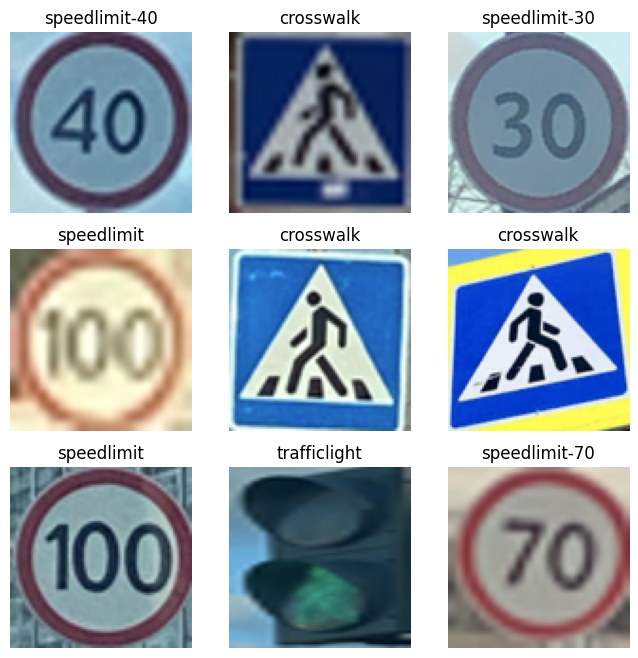

In [21]:
plt.figure(figsize=(8,8))
for i in range(9):
    idx = random.randint(0, len(X)-1)
    plt.subplot(3,3,i+1)
    plt.imshow(X[idx].astype("uint8"))
    plt.title(y[idx])
    plt.axis('off')
plt.show()


### Building the Dataset

All classifiers works best with values between 0 and 1.

In [22]:
X = X.astype("float32") / 255.0
X_flat = X.reshape(X.shape[0], -1)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)
print("Classes :", label_encoder.classes_)


Train : (995, 27648) (995,)
Test  : (249, 27648) (249,)
Classes : ['crosswalk' 'speedlimit' 'speedlimit-100' 'speedlimit-120'
 'speedlimit-30' 'speedlimit-40' 'speedlimit-5' 'speedlimit-50'
 'speedlimit-60' 'speedlimit-70' 'speedlimit-80' 'speedlimit-90' 'stop'
 'trafficlight']


## Comparison of classifiers

### Multinomial Logistic Regression

In [23]:
cls_lr = LogisticRegression()
cls_lr.fit(X_train,y_train)

C:\Users\eliot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.70      0.85      0.77        54
           2       0.55      0.50      0.52        12
           3       0.00      0.00      0.00         4
           4       1.00      0.20      0.33         5
           5       0.82      0.78      0.80        36
           6       1.00      0.67      0.80         3
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       0.75      0.75      0.75         4
          10       0.73      0.76      0.74        21
          11       1.00      1.00      1.00         8
          12       0.94      0.83      0.88        18
          13       0.80      0.82      0.81        34

    accuracy                           0.81       249
   macro avg       0.81      0.71      0.73       249
weighted avg       0.81      0.81      0.80       249



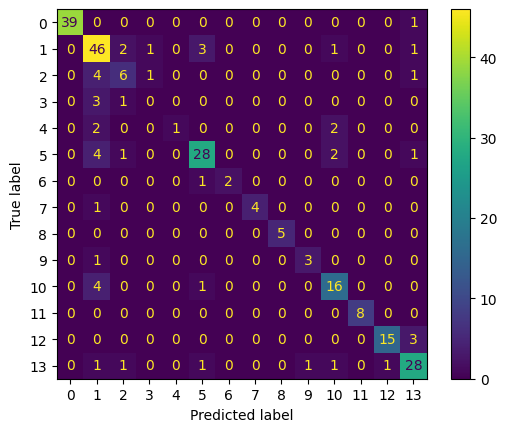

In [24]:
y_predicted_clf = cls_lr.predict(X_test)
print(classification_report(y_test, y_predicted_clf))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_clf)
plt.show()

### Support Vector Machine

In [25]:
cls_svm = svm.SVC()
cls_svm.fit(X_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


C:\Users\eliot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\eliot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\eliot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.60      0.91      0.72        54
           2       1.00      0.42      0.59        12
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         5
           5       0.73      0.83      0.78        36
           6       1.00      0.67      0.80         3
           7       1.00      0.40      0.57         5
           8       1.00      0.60      0.75         5
           9       0.00      0.00      0.00         4
          10       0.62      0.48      0.54        21
          11       1.00      0.62      0.77         8
          12       1.00      1.00      1.00        18
          13       0.89      0.97      0.93        34

    accuracy                           0.78       249
   macro avg       0.70      0.56      0.60       249
weighted avg       0.78      0.78      0.76       249



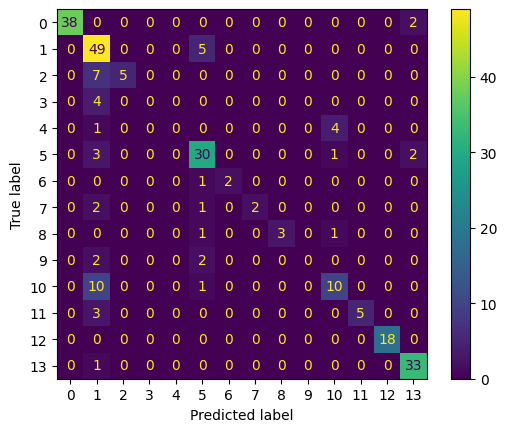

In [26]:
y_predicted_svm = cls_svm.predict(X_test)
print(classification_report(y_test, y_predicted_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_svm)
plt.show()

## Gaussian Naive Bayes

In [27]:
cls_gnb = GaussianNB()
cls_gnb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


              precision    recall  f1-score   support

           0       1.00      0.80      0.89        40
           1       0.70      0.39      0.50        54
           2       0.33      0.50      0.40        12
           3       0.22      0.50      0.31         4
           4       0.00      0.00      0.00         5
           5       0.57      0.11      0.19        36
           6       0.67      0.67      0.67         3
           7       0.25      0.60      0.35         5
           8       0.08      0.60      0.15         5
           9       0.10      0.25      0.14         4
          10       0.75      0.14      0.24        21
          11       0.26      0.62      0.37         8
          12       0.93      0.78      0.85        18
          13       0.72      0.85      0.78        34

    accuracy                           0.50       249
   macro avg       0.47      0.49      0.42       249
weighted avg       0.67      0.50      0.52       249



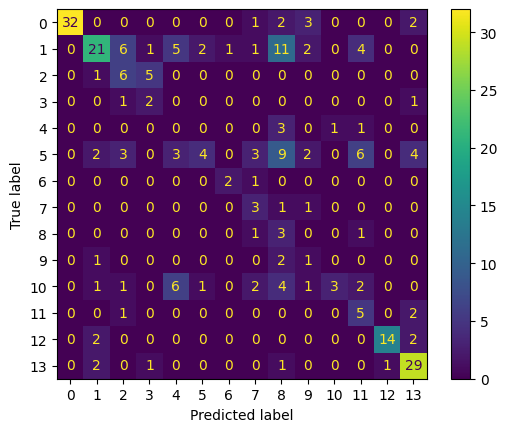

In [28]:
y_predicted_gnb = cls_gnb.predict(X_test)
print(classification_report(y_test, y_predicted_gnb))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_gnb, cmap='viridis')
plt.show()

## K Nearest Neighbors

Using the default parameters

In [29]:
cls_knn = KNeighborsClassifier(n_neighbors=5)
cls_knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.78      0.80      0.79        54
           2       0.50      0.67      0.57        12
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         5
           5       0.52      0.67      0.59        36
           6       1.00      0.67      0.80         3
           7       0.75      0.60      0.67         5
           8       0.67      0.40      0.50         5
           9       0.60      0.75      0.67         4
          10       0.65      0.71      0.68        21
          11       0.62      0.62      0.62         8
          12       0.89      0.94      0.92        18
          13       1.00      0.74      0.85        34

    accuracy                           0.74       249
   macro avg       0.66      0.62      0.63       249
weighted avg       0.76      0.74      0.74       249



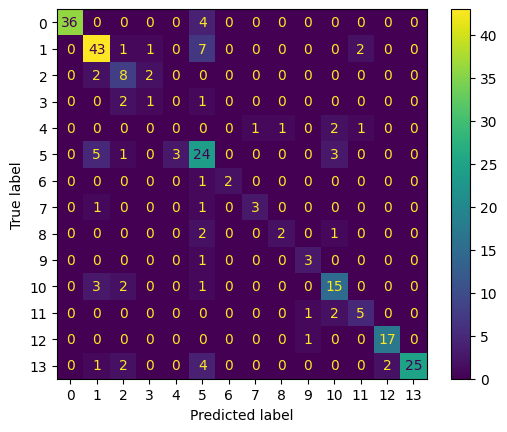

In [30]:
y_predicted_knn = cls_knn.predict(X_test)
print(classification_report(y_test, y_predicted_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_knn)
plt.show()

Parameters tuning to find the best accuracy (simple brutefirce over $n$ and the weight function)

In [31]:
best_accuracy = 0
best_params = {}
for n_neighbors in range(1, 11):
    for weights in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_train, y_train)
        y_predicted_knn = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted_knn)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_neighbors': n_neighbors, 'weights': weights}
print(f'Best accuracy: {best_accuracy}')
print(f'Best parameters: {best_params}')

Best accuracy: 0.8032128514056225
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}


## Conclusion

Even if it takes time to run, the most accurate classifier is the Support Vector Machine classifier

After obtaining the satisfying accuracy display numbers which the model misclassified.

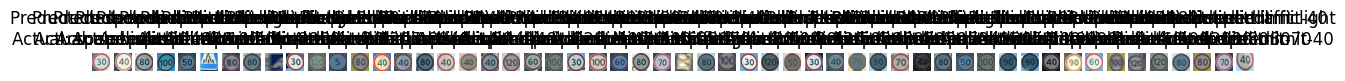

In [32]:
y_missclassified_mask = y_predicted_svm != y_test

y_missclassified_computed = label_encoder.inverse_transform(y_predicted_svm[y_missclassified_mask])
y_missclassified_test = label_encoder.inverse_transform(y_test[y_missclassified_mask])
X_missclassified = X_test[y_missclassified_mask]

n = len(y_missclassified_computed)

X_missclassified = (X_missclassified.astype("float32") * 255.0).astype("uint8")

fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(15, 3))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(X_missclassified[i].reshape(96, 96, 3))
    plt.title("Preducted: " + y_missclassified_computed[i] + "\nActual: " + y_missclassified_test[i])
    plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 27648 into shape (8,8)

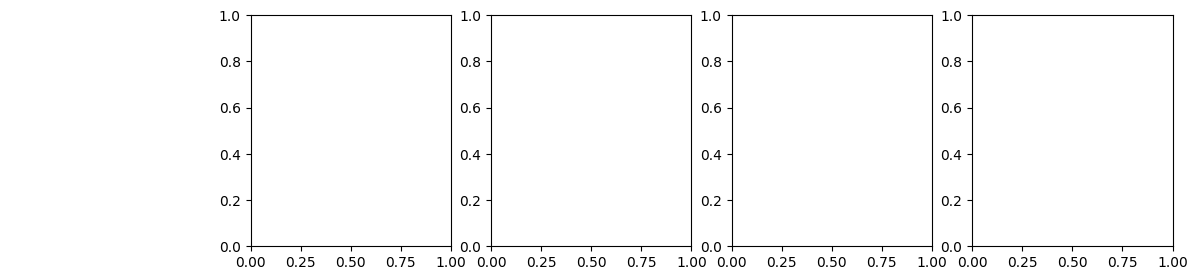

In [36]:

#knn = KNeighborsClassifier(**best_params)
#knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)
predicted = cls_svm.predict(X_test)
misclassified_indices = np.where(predicted != y_test)[0]
fig, axes = plt.subplots(nrows=1, ncols=len(misclassified_indices), figsize=(15, 3))
for ax, index in zip(axes, misclassified_indices):
    ax.set_axis_off()
    ax.imshow(X_test[index].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'True:{y_test[index]}\nPred:{predicted[index]}')
plt.show()